# The purpose of this notebook is to get data from multiple data sources and transform them to common structure.

In [57]:
import pandas as pd
import string
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
from sklearn.model_selection import train_test_split

In [58]:
# VARIABLES
pd.options.mode.chained_assignment = None
DF_MERGED_DELETE_OUTLIERS = True

In [59]:
def text_analysis(df, colname='title'):
    """
    counts: capital letters, small letters, special characters, blank signs, numbers, letters (small + capital)
    """
    nan_titles = df.isnull().values.any() 
    print(f"\nNaN titles dropped: { nan_titles }")
    df = df.dropna(subset=[colname])
    
    df["char_capital"] = df.get(colname).apply(lambda title: sum(1 for char in title if char.isupper()))
    df["char_small"] = df.get(colname).apply(lambda title: sum(1 for char in title if char.islower()))
    df["char_special"] = df.get(colname).apply(lambda title: sum(1 for char in title if not char.isalnum() and not char.isspace()))
    df["blank"] = df.get(colname).apply(lambda title: sum(1 for char in title if char.isspace()))
    df["numerical"] = df.get(colname).apply(lambda title: sum(1 for char in title if char.isdigit())) 
    df["letters"] = df.get(colname).apply(lambda title: sum(1 for char in title if char.isalpha()))
    
    # print(f"\nEmpty titles dropped: {sum(df["letters"] == 0)}")
    df = df.loc[df["letters"]!=0]
    return df

In [60]:
def plot_letters(df, log_scale=False):
    """
    plots boxplot and histogram with number of letters
    """
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    df.boxplot(column=["letters"], ax=axs[0])
    axs[0].set_title('Boxplot of alphabetical characters in titles')
    if log_scale:
        axs[0].set_yscale('log')

    sns.histplot(df["letters"], bins=10, kde=False, ax=axs[1], edgecolor="black")
    axs[1].set_xlabel('Counts')
    axs[1].set_ylabel('Frequency')
    axs[1].set_title('Histogram of alphabetical characters in titles')
    if log_scale:
        axs[1].set_yscale('log')

    plt.tight_layout()
    plt.show()

In [61]:
def outliers_iqr(df):
    """
    detect outliers by IQR criteria
    returns outliers Pandas.df and updated original df
    """
    Q1 = df["letters"].quantile(0.25)
    Q3 = df["letters"].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df["outlier"] = np.where((df["letters"] < lower_bound) | (df["letters"] > upper_bound), 1, 0)
    outliers = df[df["outlier"]==1].copy()
    outliers["tail"] = outliers["letters"].apply(lambda count: "L" if count < lower_bound else "U")
    outliers = outliers.groupby(["tail", "clickbait"])["clickbait"].count().reset_index(name='count')
    return outliers, df

In [62]:
def plot_outliers(outliers):
    """
    plots 2 barplots with outliers above and beneath bounds
    """
    lower_outliers = outliers[outliers['tail'] == 'L']
    upper_outliers = outliers[outliers['tail'] == 'U']

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    sns.barplot(x='clickbait', y='count', data=lower_outliers, ax=axs[0], hue="clickbait", palette={0: 'green', 1: 'red'})
    axs[0].set_title('Less alphabetical than lower bound IQR')
    axs[0].set_xlabel('Clickbait')
    axs[0].set_ylabel('Count')
    axs[0].set_xticks(ticks=[0, 1], labels=['Non-Clickbait (0)', 'Clickbait (1)'])

    sns.barplot(x='clickbait', y='count', data=upper_outliers, ax=axs[1], hue="clickbait", palette={0: 'green', 1: 'red'})
    axs[1].set_title('More alphabetical than upper bound IQR')
    axs[1].set_xlabel('Clickbait')
    axs[1].set_ylabel('Count')
    axs[1].set_xticks(ticks=[0, 1], labels=['Non-Clickbait (0)', 'Clickbait (1)'])

    plt.tight_layout()
    plt.show()

In [63]:
def clickbait_dist_plot(df):
        """
        piechart with clickbait distribution
        """
        print(f"\nShape: {df.shape}")
        num_clickbaits = df[df["clickbait"] == 1].shape[0]
        num_no_clickbaits = df[df["clickbait"] == 0].shape[0]

        print(f"Number of clickbaits: {num_clickbaits}")
        print(f"Number of no-clickbaits: {num_no_clickbaits}")

        labels = ['Clickbait', 'No-clickbait']
        sizes = [num_clickbaits, num_no_clickbaits]
        colors = ['red', 'green']
        explode = (0, 0)

        plt.figure(figsize=(8, 6))
        plt.pie(sizes, explode=explode, labels=labels, colors=colors,
                autopct='%1.1f%%', shadow=False, startangle=90)
        plt.axis('equal')
        plt.title('Distribution of Clickbaits and No Clickbaits')
        plt.show()

In [64]:
def plot_clickbait_vs_noclickbait(df):
    """
    plots boxplots with comparison in features between clickbait and no-clickbait articles
    """
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))

    data_1 = df[df["char_capital"] >= df["char_small"]]
    data_2 = df[df["numerical"] != 0]
    data_3 = df[df["char_special"] != 0]
    titles = [
        'Titles with more capital than small letters',
        'Titles with numerical data',
        'Titles with special characters'
    ]
    datasets = [data_1, data_2, data_3]

    for i in range(len(datasets)):
        dataset = datasets[i].groupby(["clickbait"])["clickbait"].count().reset_index(name='count')
        axs[i].bar(dataset['clickbait'], dataset['count'], color=['green', 'red'])

        axs[i].set_xlabel('Clickbait (0 = No, 1 = Yes)')
        axs[i].set_ylabel('Count')
        axs[i].set_title(titles[i])
        axs[i].set_xticks(dataset['clickbait'])

        axs[i].grid(axis='y')

    plt.tight_layout()
    plt.show()

In [65]:
def remove_outliers(df):
    return df.loc[df["outlier"]==0]

In [66]:
def print_stats(df):
    stats = df.drop(columns=["title"]).groupby('clickbait').agg(['mean', 'std'])
    print("\nStats:\n", stats)

In [67]:
def analyze_df(df, delete_outliers=False):
    """
    pipeline with above methods
    """
    columns = df.columns.tolist()
    print(f"Columns: {columns}")
    clickbait_dist_plot(df)
    df = text_analysis(df)
    print_stats(df)
    print("With outliers:")
    plot_letters(df)
    outliers, df = outliers_iqr(df)
    plot_outliers(outliers)
    if delete_outliers:    
        df = remove_outliers(df)
        print("Without outliers:")
        plot_letters(df)
    plot_clickbait_vs_noclickbait(df)
    # return df[columns]
    return df

 ## #1 Data source: kaggle
 https://www.kaggle.com/datasets/amananandrai/clickbait-dataset

In [68]:
df_1 = pd.read_csv("../data/clickbait_data.csv").drop_duplicates()
df_1.rename(columns={'headline': 'title'}, inplace=True)

Columns: ['title', 'clickbait']

Shape: (32000, 2)
Number of clickbaits: 15999
Number of no-clickbaits: 16001


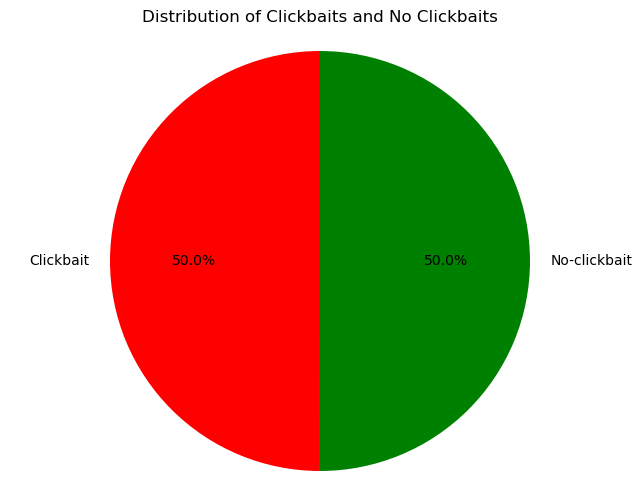


NaN titles dropped: False

Stats:
           char_capital           char_small            char_special            \
                  mean       std       mean        std         mean       std   
clickbait                                                                       
0             4.631273  2.469242  38.795013  12.265831     0.721455  1.015306   
1             9.688356  2.866690  35.308957  10.295818     0.754047  1.074927   

              blank           numerical              letters             
               mean       std      mean       std       mean        std  
clickbait                                                                
0          7.194988  2.227746  0.510593  1.248460  43.426286  12.262935  
1          8.942684  2.660435  1.047003  1.427426  44.997312  12.532420  
With outliers:


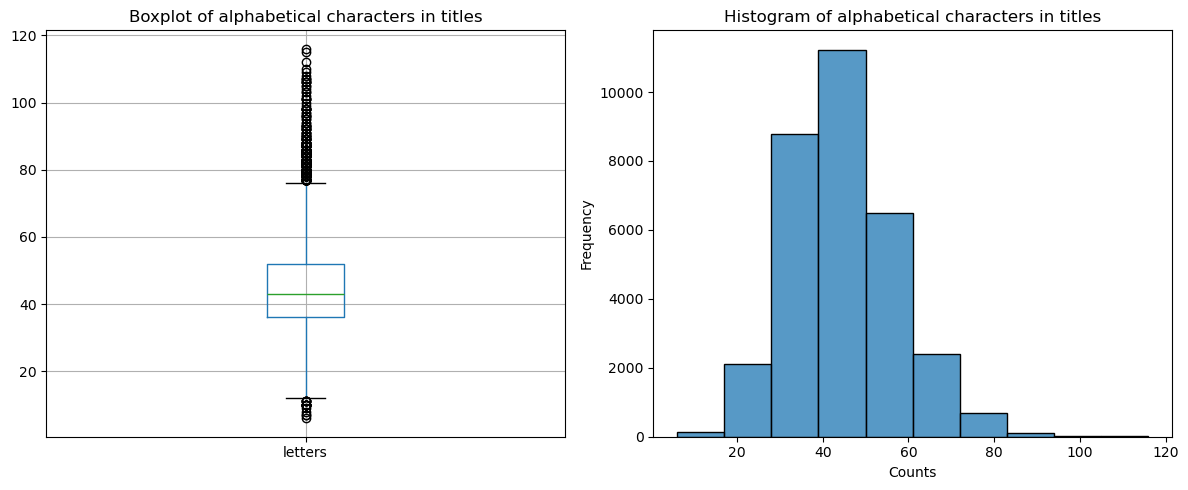

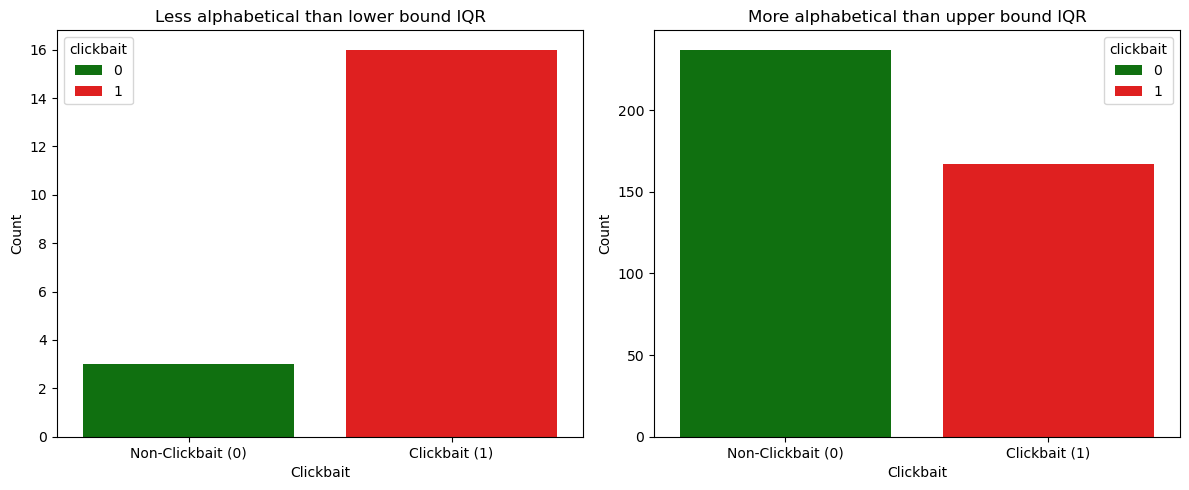

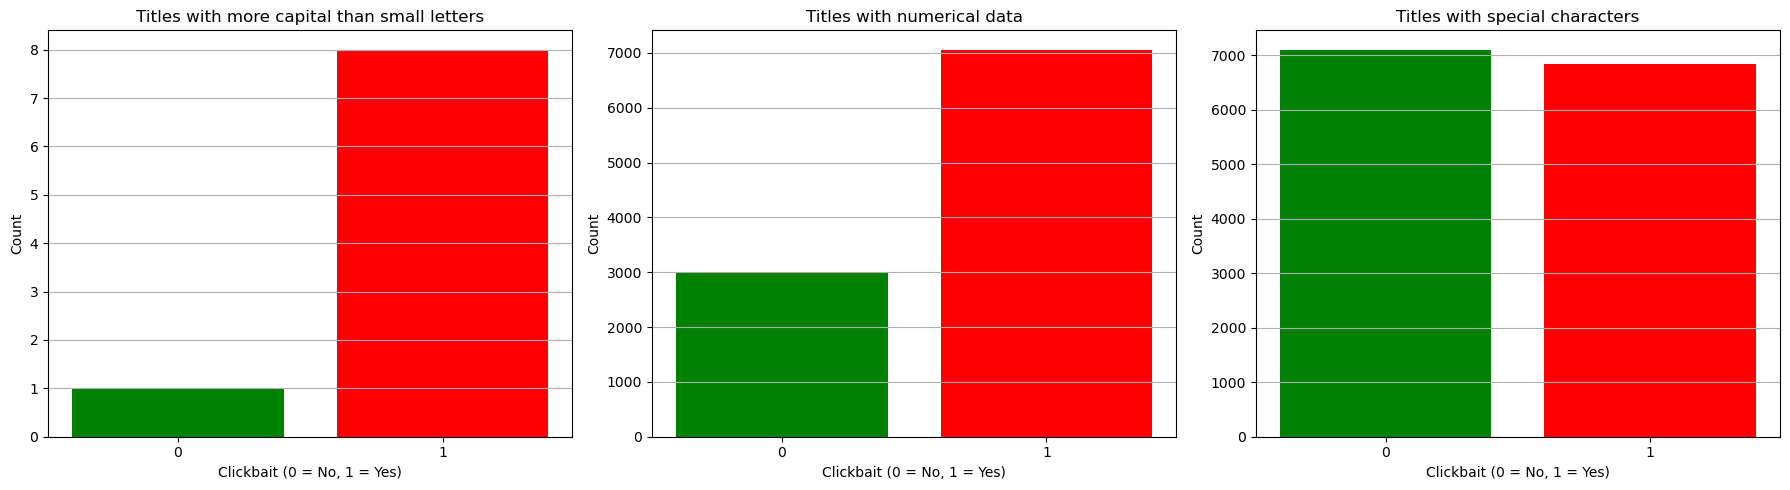

,title,clickbait,char_capital,char_small,char_special,blank,numerical,letters,outlier
0,Should I Get Bings,1,4,11,0,3,0,15,0
1,Which TV Female Friend Group Do You Belong In,1,10,27,0,8,0,37,0
2,"The New ""Star Wars: The Force Awakens"" Trailer...",1,14,43,3,13,0,57,0
3,"This Vine Of New York On ""Celebrity Big Brothe...",1,12,42,2,11,0,54,0
4,A Couple Did A Stunning Photo Shoot With Their...,1,18,65,0,17,0,83,1
...,...,...,...,...,...,...,...,...,...
31995,"To Make Female Hearts Flutter in Iraq, Throw a...",0,8,33,1,9,0,41,0
31996,"British Liberal Democrat Patsy Calton, 56, die...",0,5,40,2,8,2,45,0
31997,Drone smartphone app to help heart attack vict...,0,1,63,0,11,0,64,0
31998,"Netanyahu Urges Pope Benedict, in Israel, to D...",0,7,41,2,8,0,48,0


In [69]:
df_1.head()
analyze_df(df_1)

 ## #2 Data source: kaggle 
https://www.kaggle.com/datasets/vikassingh1996/news-clickbait-dataset?select=train2.csv

In [70]:
df_news_2 = pd.read_csv("../data/train2.csv").drop_duplicates()
df_news_2['label'] = df_news_2['label'].apply(lambda x: 1 if x == 'clickbait' else 0)

df_news_2.rename(columns={'label': 'clickbait'}, inplace=True)
df_2 = df_news_2[['title', 'clickbait']]

Columns: ['title', 'clickbait']

Shape: (20914, 2)
Number of clickbaits: 4266
Number of no-clickbaits: 16648


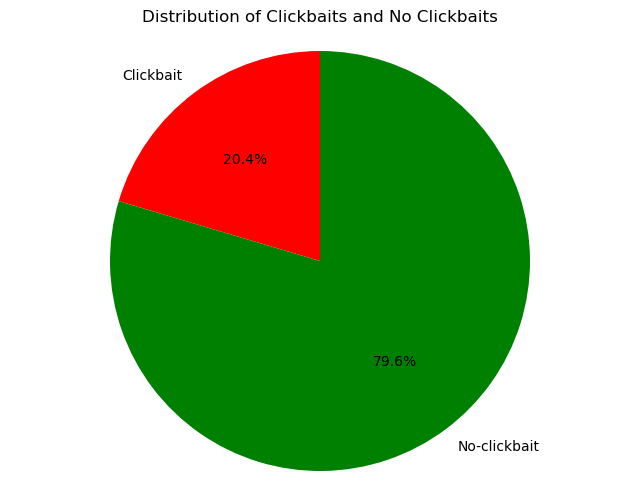


NaN titles dropped: False

Stats:
           char_capital           char_small            char_special            \
                  mean       std       mean        std         mean       std   
clickbait                                                                       
0             7.016759  7.617762  54.441434  77.798081     1.822081  2.491760   
1             7.557900  8.099386  52.431317  88.317583     1.751055  2.745288   

               blank            numerical              letters             
                mean        std      mean       std       mean        std  
clickbait                                                                  
0          11.308626  15.975101  0.563371  1.520986  61.458193  83.902051  
1          11.522504  18.491532  0.802625  1.670221  59.989217  94.619246  
With outliers:


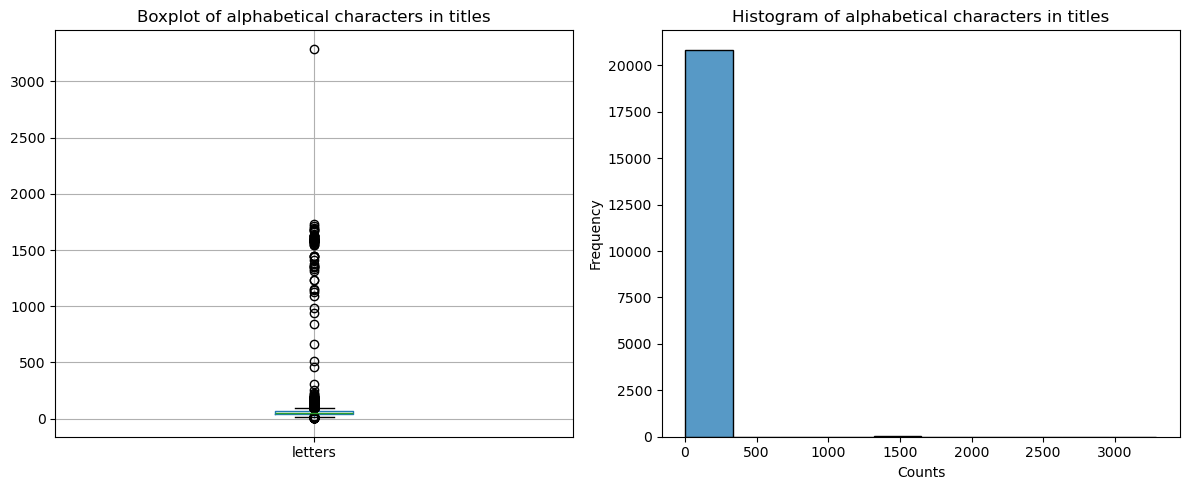

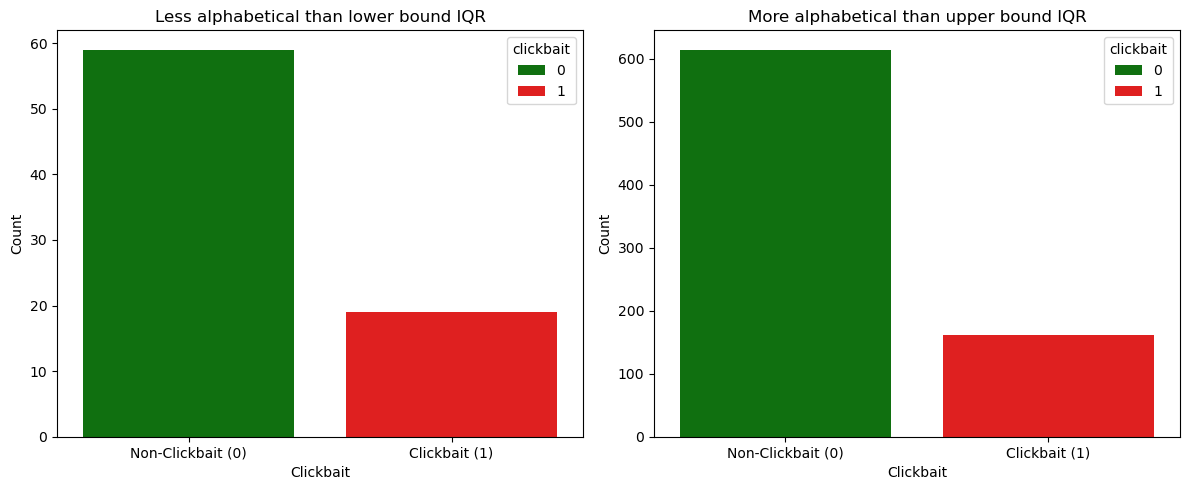

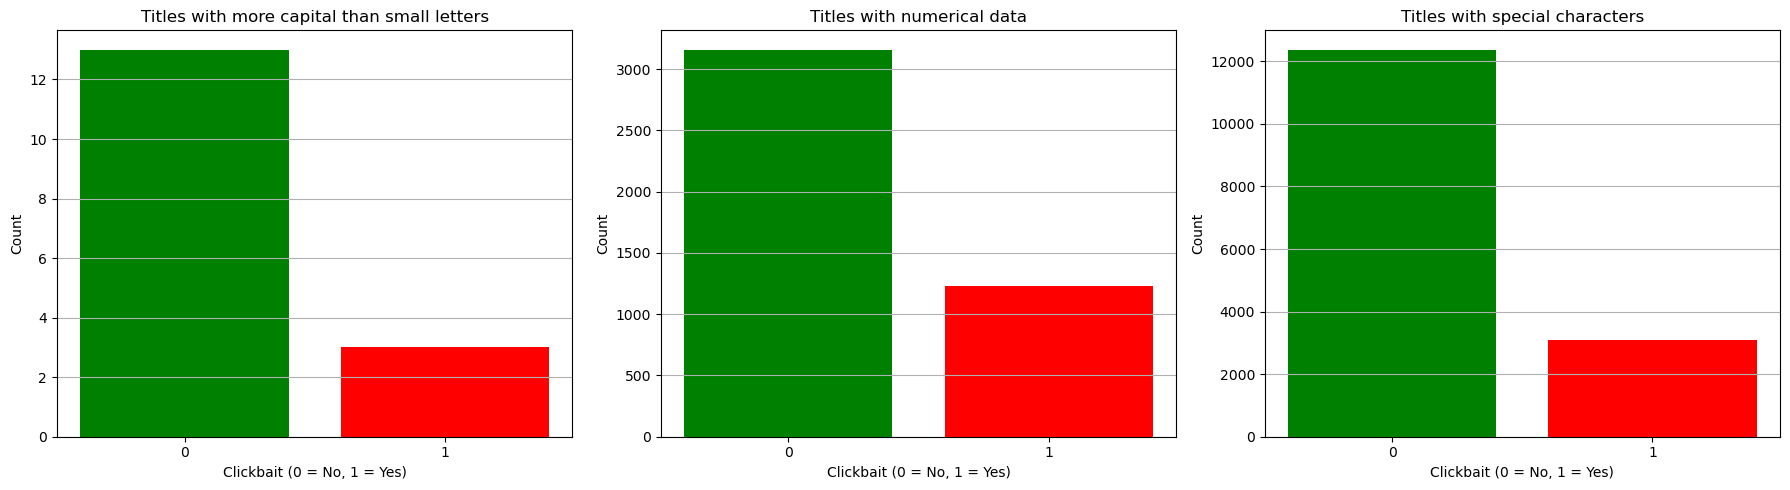

In [71]:
df_2.head()
df_2 = analyze_df(df_2)

 ## #3 Data source: clickbait challenge 
https://webis.de/events/clickbait-challenge/shared-task.html

In [72]:
def load_data_cc(name, columns=[]):
    """
    loads data from clickbait challenge webis corpus
    
    name (str): name of the folder
    columns (list): list of columns names to extract apart from 'id' and 'targetTitle'
    """
    data_file_path = f'../data/{name}/instances.jsonl'
    with open(data_file_path, 'rb') as file:
        data_df = pd.read_json(file,lines=True)

    target_file_path = f'../data/{name}/truth.jsonl'
    with open(target_file_path, 'rb') as file:
        labels = pd.read_json(file,lines=True)
    
    data_df = data_df[["id", "targetTitle"] + columns]
    labels = labels[["id", "truthClass"]]

    df = pd.merge(data_df, labels, on='id', how='left')
    df.drop(['id'], axis=1, inplace=True)
    df['truthClass'] = df['truthClass'].apply(lambda x: 1 if x == 'clickbait' else 0)
    df.rename(columns={'targetTitle': 'title', 'truthClass': 'clickbait'}, inplace=True)
    return df

In [73]:
files = [
    "clickbait17-train-170331", 
    "clickbait17-test-170720", 
    "clickbait17-validation-170630"
]
body_dfs = []
for filename in files:
    part_df = load_data_cc(filename)
    part_df = part_df[['title', 'clickbait']]
    body_dfs.append(part_df)
df_3 = pd.concat(body_dfs).reset_index(drop=True)
df_3 = df_3.drop_duplicates()

print(df_3.shape)

(38830, 2)


Columns: ['title', 'clickbait']

Shape: (38830, 2)
Number of clickbaits: 9530
Number of no-clickbaits: 29300


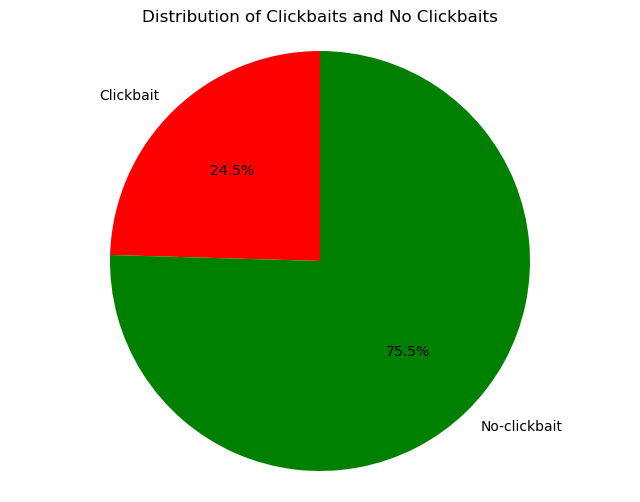


NaN titles dropped: False

Stats:
           char_capital           char_small            char_special            \
                  mean       std       mean        std         mean       std   
clickbait                                                                       
0             7.042082  7.195388  54.745427  69.125018     1.758020  2.729074   
1             7.500105  8.239454  50.947429  73.271862     1.765582  2.750367   

               blank            numerical              letters             
                mean        std      mean       std       mean        std  
clickbait                                                                  
0          11.378498  14.259585  0.590410  1.492527  61.787509  74.467116  
1          11.241658  15.637764  0.804512  1.803112  58.449213  79.268846  
With outliers:


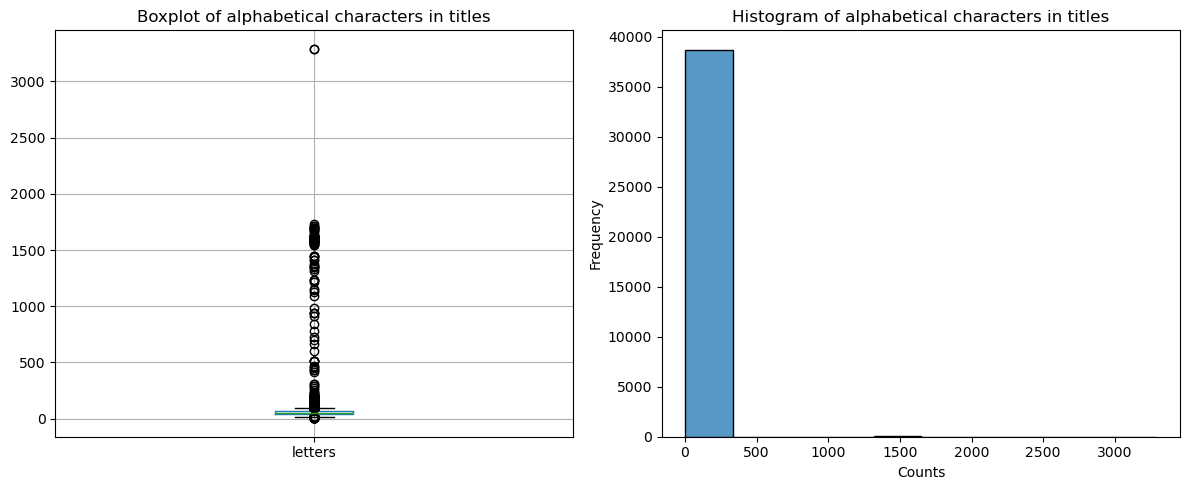

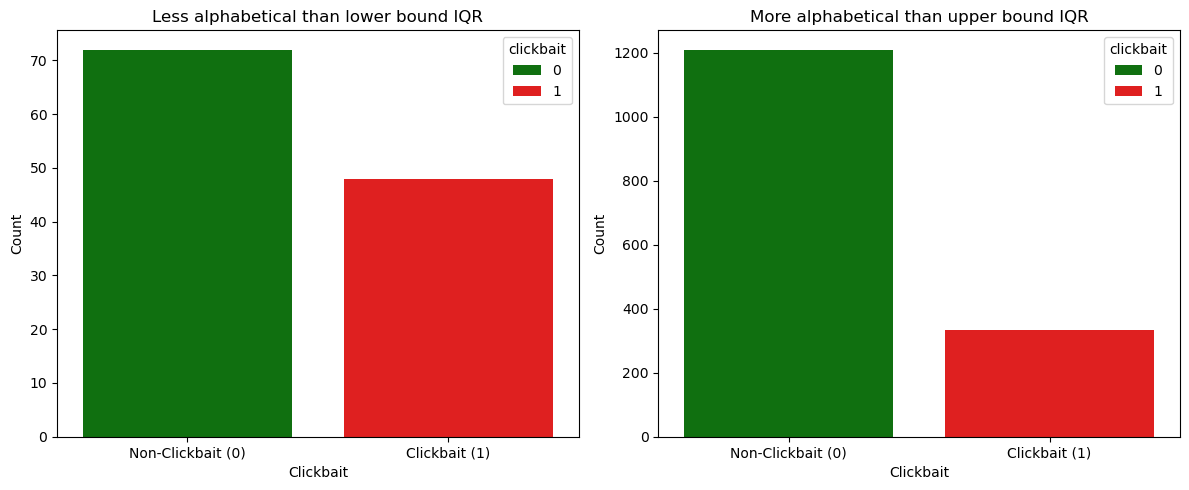

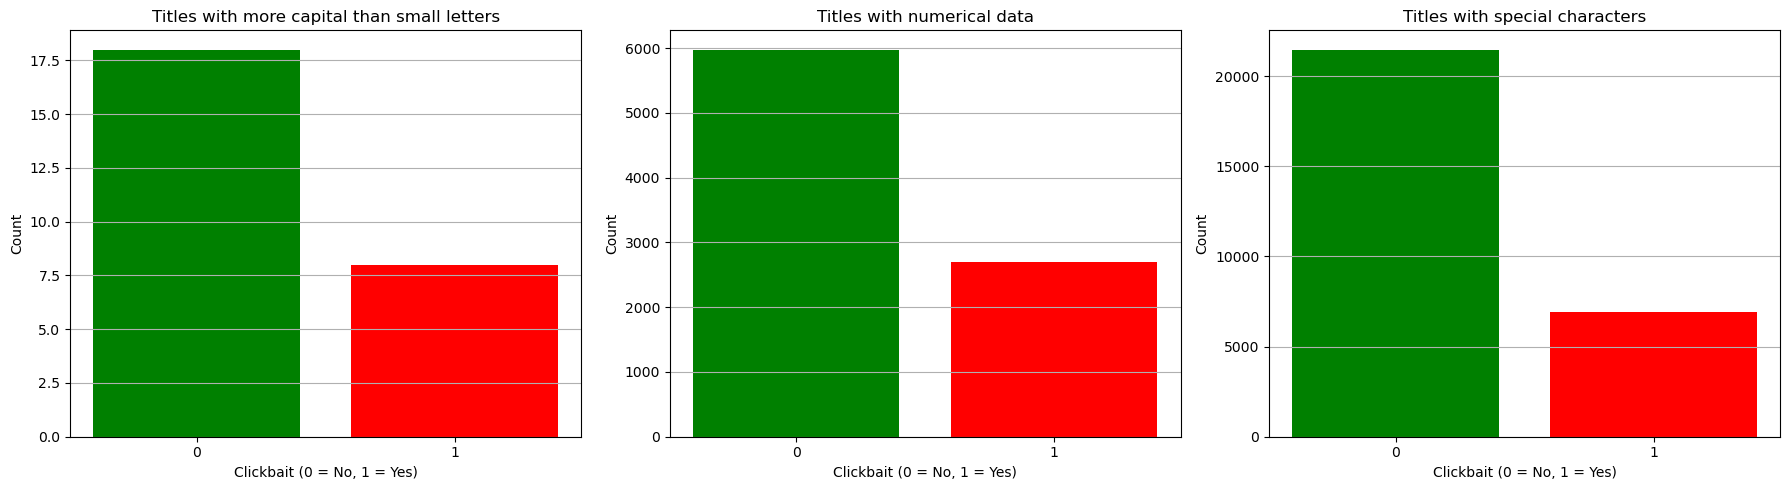

,title,clickbait,char_capital,char_small,char_special,blank,numerical,letters,outlier
0,Apple gives back gigabytes: iOS 9 'app thinnin...,0,3,79,4,16,1,82,0
1,Emerging Markets Suffer Largest Outflow in Sev...,0,7,40,0,7,0,47,0
2,U.S. Soccer should start answering tough quest...,1,5,50,2,9,0,55,0
3,How theme parks like Disney World left the mid...,0,3,49,0,10,0,52,0
4,Warning labels on your light bulbs,1,1,28,0,5,0,29,0
...,...,...,...,...,...,...,...,...,...
40971,"NBC News Video See Brazil Soccer Team, Pilot’s...",0,15,53,2,12,0,68,0
40972,Politico Scoop: Eric Trump Killed Two Deer,1,7,28,1,6,0,35,0
40973,Frenchs Forest high school may relocate to mak...,0,2,83,1,16,0,85,0
40974,Los Angeles Rams Jeff Fisher May Think Danny W...,0,12,57,0,13,0,69,0


In [74]:
df_3.head()
analyze_df(df_3)

## Datasets Clickbait distribution

In [75]:
def calc_dist_by_set(df_temp):
    df_counts = df_temp.groupby(["set", "clickbait"]).count().reset_index()
    df_counts.rename(columns={'title': 'counts'}, inplace=True)

    merged = df_counts.groupby("set")["counts"].sum().reset_index()
    merged.rename(columns={'counts': 'total_titles'}, inplace=True)

    df_counts = df_counts.merge(merged, on='set')
    df_counts["perc"] = round((df_counts["counts"] / df_counts["total_titles"]) * 100, 1)
    df_counts.drop(columns='total_titles', inplace=True)

    all = df_counts.groupby(["clickbait"]).sum()["counts"]
    per1 = round(all[0]/all.sum() * 100, 1)
    per2 = round(100 - per1, 1)
    p = df_counts["perc"].tolist()
    p.append(per1)
    p.append(per2)
    p = [str(str(label)+"%") for label in p]
    labels = [f"Kaggle 1 {[p[0], p[1]]}", f"Kaggle 2 {[p[2], p[3]]}", f"Challange {[p[4], p[5]]}", f"No-Clickbait {[p[6]]}", f"Clickbait {[p[7]]}"]
    for label in labels:
        print(label)
    return labels, df_counts

In [76]:
def plot_dist_by_set(labels, df_counts):
    values = df_counts["counts"].to_list()
    sources = [0, 0, 1, 1, 2, 2]  # Set 1, Set 1, Set 2, Set 2, Set 3, Set 3
    targets = [3, 4, 3, 4, 3, 4]  # Clickbait, No-Clickbait for each set

    values = df_counts["counts"].to_list() 
    # node_colors = px.colors.qualitative.Plotly
    node_colors = ["#63e0e0", "#8b95d9", "#dbca0b", "#6fed91", "#e64769"]  # Colors for Set 1, Set 2, Set 3, Clickbait, No-Clickbait
    link_colors = ["#6fed91", "#e64769", "#6fed91", "#e64769", "#6fed91", "#e64769"]

    fig = go.Figure(data=[go.Sankey(
        orientation="v",
        node=dict(
            pad=5,
            thickness=28,
            line=dict(color="black", width=0.5),
            label=labels,
            color=node_colors
        ),
        link=dict(
            source=sources,
            target=targets,
            value=values,
            color=link_colors
        )
    )])


    fig.update_layout(
        title_text="",
        font_size=20
        )

    fig.show()

## Concatenate datasets

In [77]:
dfs = [
    df_1,
    df_2,
    df_3,
]

for df_ in dfs:
    print(df_.shape)

(32000, 2)
(20914, 9)
(38830, 2)


In [78]:
for i,df_ in enumerate(dfs):
    print("=========  " + str(i+1) +"- dataset =============")
    print(df_["clickbait"].value_counts())

=========  1- dataset =============
clickbait
0    16001
1    15999
Name: count, dtype: int64
=========  2- dataset =============
clickbait
0    16648
1     4266
Name: count, dtype: int64
=========  3- dataset =============
clickbait
0    29300
1     9530
Name: count, dtype: int64


In [79]:
df_1["set"] = 1
df_2["set"] = 2
df_3["set"] = 3
df_temp = pd.concat([df_1, df_2, df_3])

labels, df_counts = calc_dist_by_set(df_temp)
plot_dist_by_set(labels, df_counts)

Kaggle 1 ['50.0%', '50.0%']
Kaggle 2 ['79.6%', '20.4%']
Challange ['75.5%', '24.5%']
No-Clickbait ['67.5%']
Clickbait ['32.5%']


In [80]:
df_merged = pd.concat([df_1,df_2,df_3])
total = df_merged.shape[0]
num_clickbait = df_merged.loc[df_merged["clickbait"]==0].shape[0]
print("total shape: ", total)
print("only non-clickbait:", num_clickbait, f"({round(num_clickbait/total*100, 2)}%)")
print("only clickbait:", total-num_clickbait, f"({round((total-num_clickbait)/total*100, 2)}%)")

total shape:  91744
only non-clickbait: 61949 (67.52%)
only clickbait: 29795 (32.48%)


In [81]:
df_merged = df_merged.drop_duplicates()
df_merged.shape

(91744, 10)

Columns: ['title', 'clickbait', 'set', 'char_capital', 'char_small', 'char_special', 'blank', 'numerical', 'letters', 'outlier']

Shape: (91744, 10)
Number of clickbaits: 29795
Number of no-clickbaits: 61949


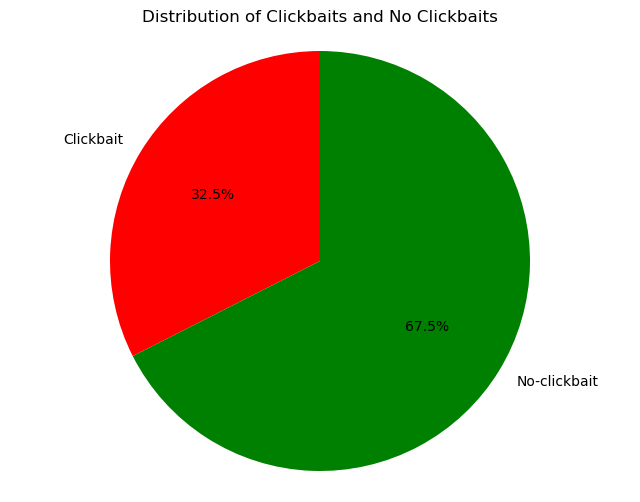


NaN titles dropped: True

Stats:
                 set           char_capital           char_small             \
               mean       std         mean       std       mean        std   
clickbait                                                                    
0          2.214677  0.827761     6.412581  6.539191  50.543851  63.034527   
1          1.782883  0.899838     8.683403  6.057029  42.762510  54.361953   

          char_special                blank            numerical            \
                  mean       std       mean        std      mean       std   
clickbait                                                                    
0             1.507498  2.381836  10.279149  13.013257  0.562527  1.441835   
1             1.220339  2.090653  10.047391  11.505769  0.934452  1.596223   

             letters              outlier            
                mean        std      mean       std  
clickbait                                            
0          56.956432 

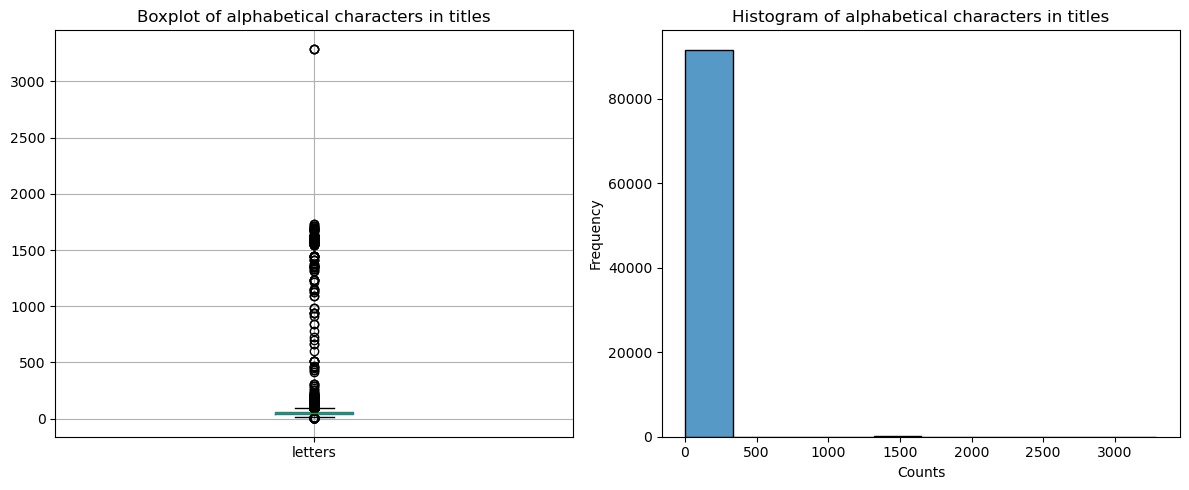

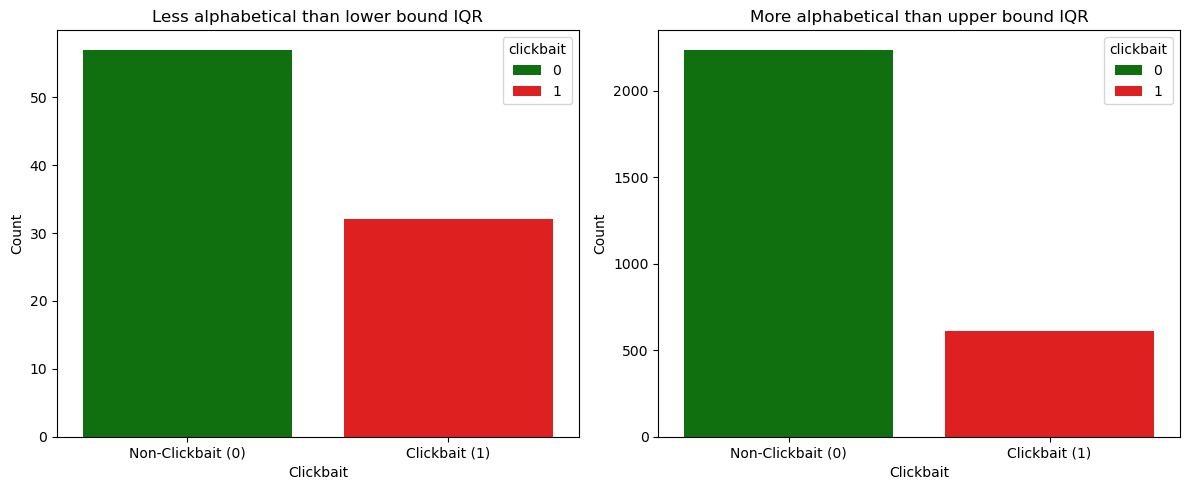

Without outliers:


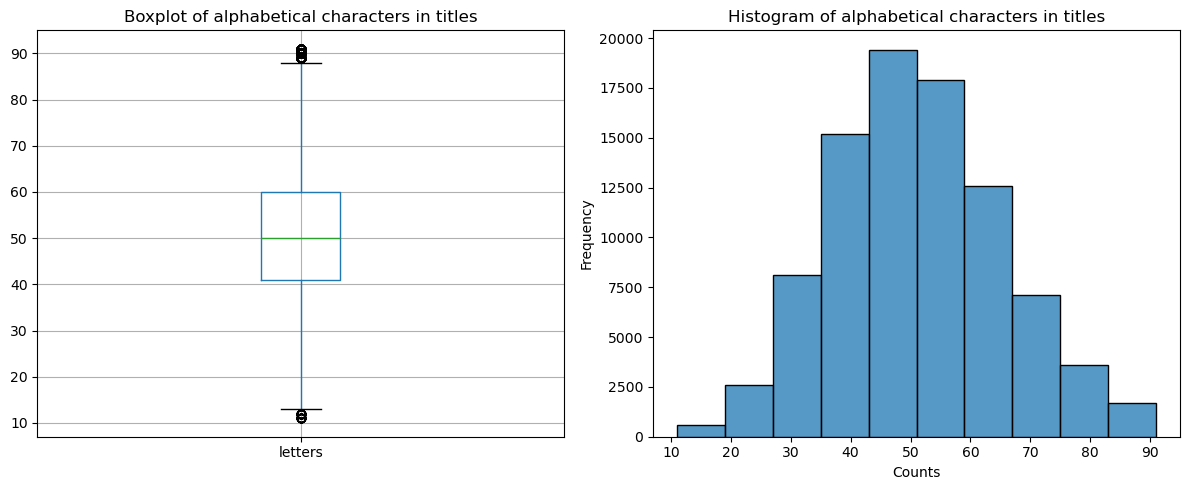

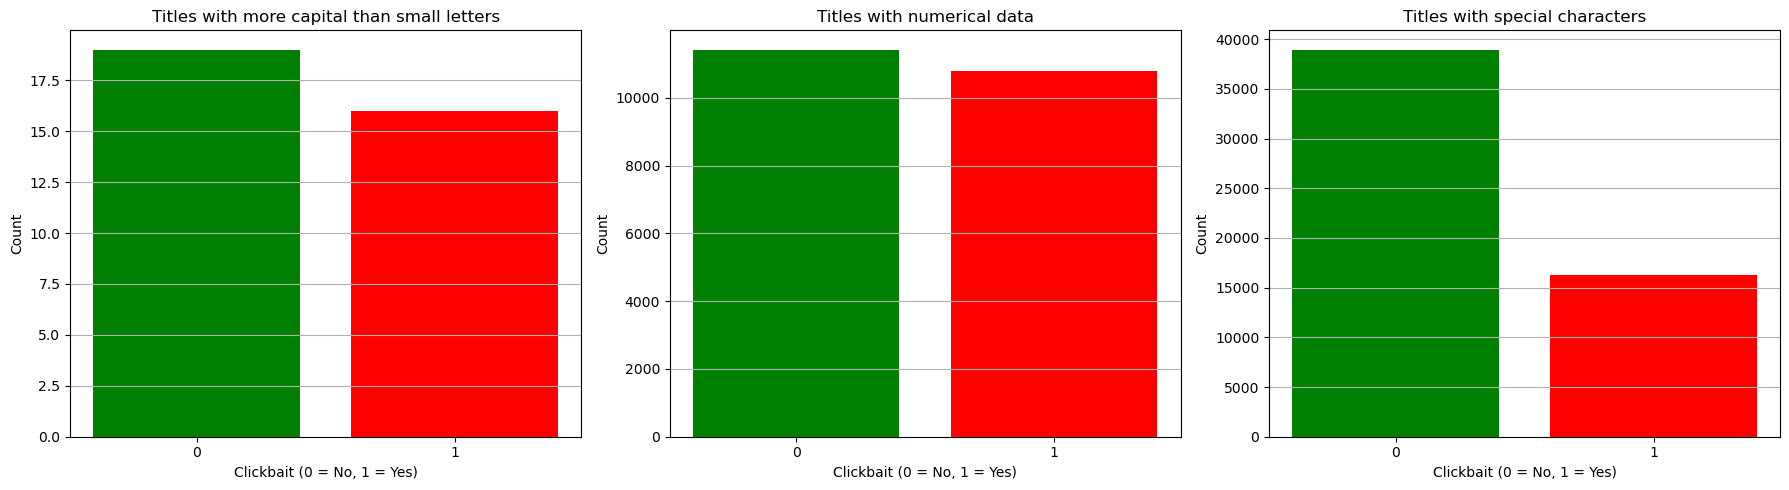

In [82]:
df_merged = analyze_df(df_merged, delete_outliers=DF_MERGED_DELETE_OUTLIERS)

In [83]:
df_merged[df_merged['title'].str.contains('到')]

,title,clickbait,set,char_capital,char_small,char_special,blank,numerical,letters,outlier
35651,欢迎来到义乌：中国的多元文化试验田,1,3,0,0,1,0,0,16,0


In [84]:
df_merged = df_merged[~df_merged['title'].str.contains('到', na=False)]

In [85]:
df_merged[df_merged['title'].str.contains('到')]

,title,clickbait,set,char_capital,char_small,char_special,blank,numerical,letters,outlier


In [86]:
df_merged.to_csv("../data/merged_all_datasets.csv", index=False)

Columns: ['title', 'clickbait', 'set', 'char_capital', 'char_small', 'char_special', 'blank', 'numerical', 'letters', 'outlier']

Shape: (88805, 10)
Number of clickbaits: 29150
Number of no-clickbaits: 59655


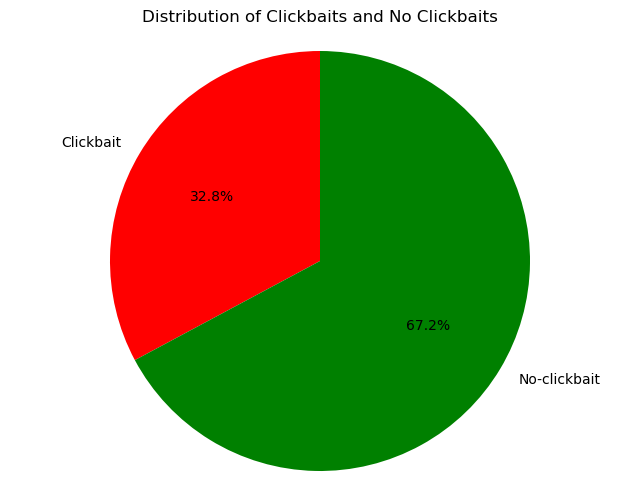


NaN titles dropped: False

Stats:
                 set           char_capital           char_small             \
               mean       std         mean       std       mean        std   
clickbait                                                                    
0          2.198692  0.833188     6.165183  3.998072  45.693923  13.542895   
1          1.764185  0.897143     8.525798  3.999803  39.674305  12.995799   

          char_special               blank           numerical            \
                  mean       std      mean       std      mean       std   
clickbait                                                                  
0             1.387143  1.472675  9.274596  3.047497  0.523912  1.264959   
1             1.132281  1.372304  9.404631  2.959922  0.918868  1.462830   

             letters            outlier       
                mean        std    mean  std  
clickbait                                     
0          51.859107  14.196835     0.0  0.0  
1   

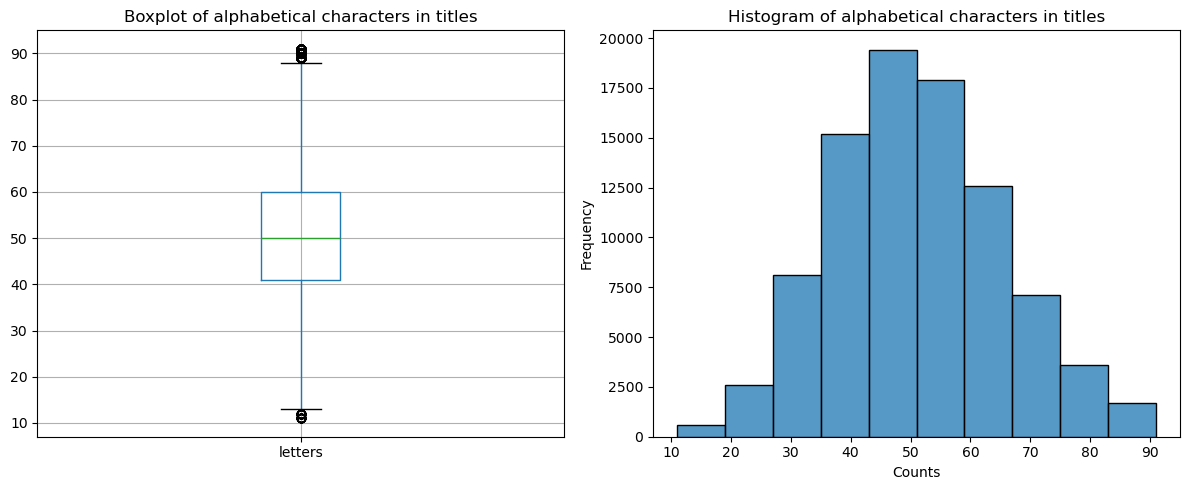

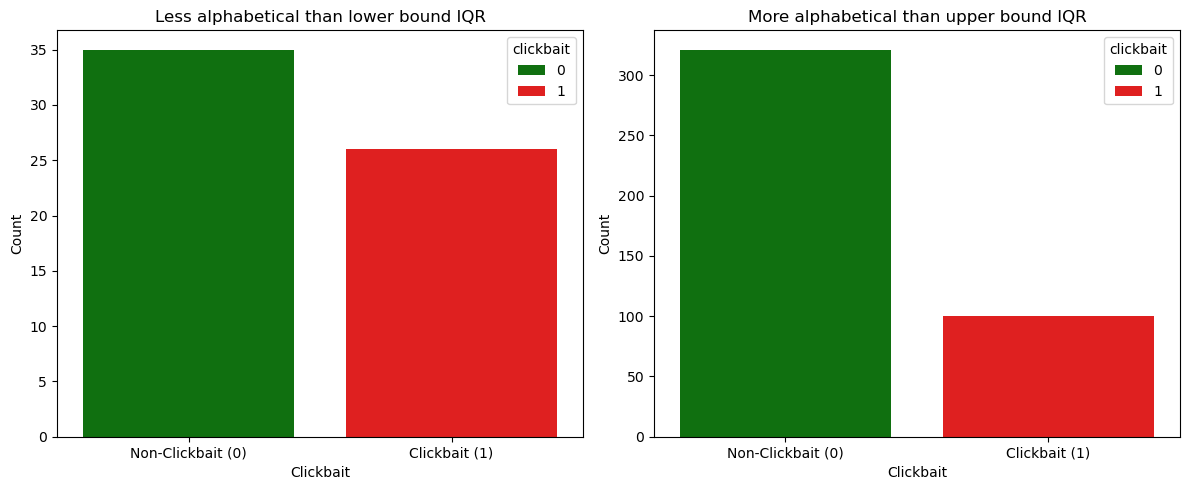

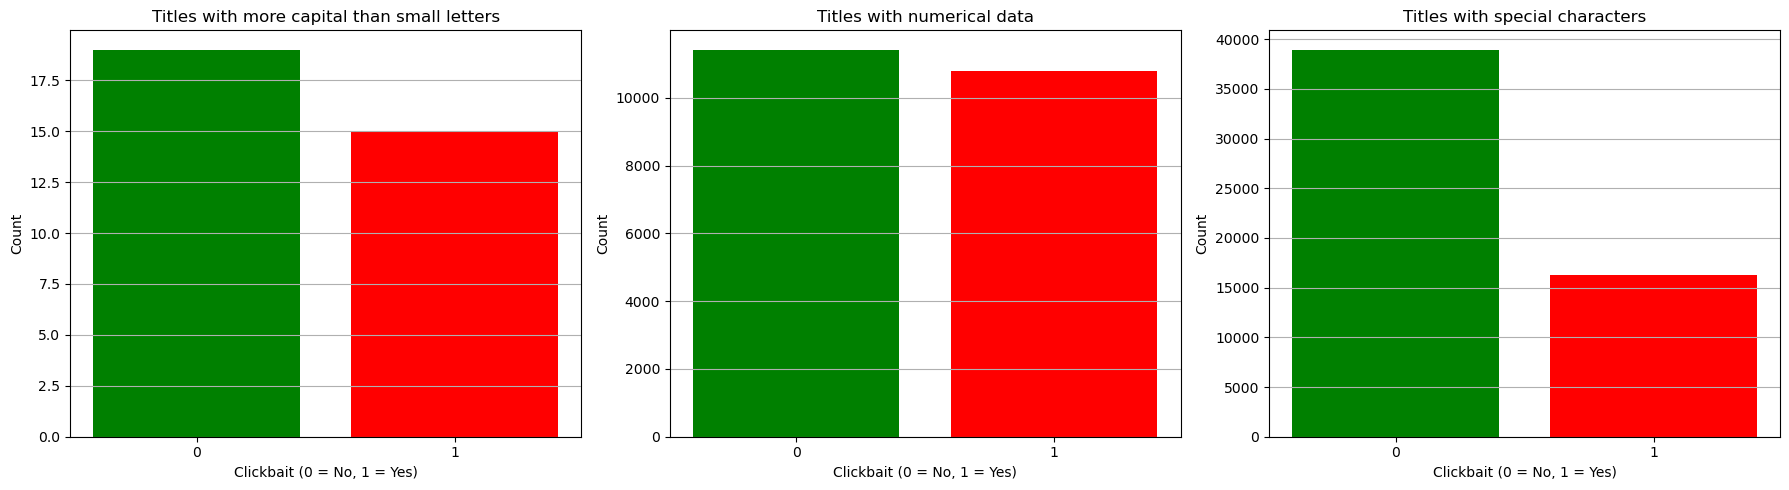

,title,clickbait,set,char_capital,char_small,char_special,blank,numerical,letters,outlier
0,Should I Get Bings,1,1,4,11,0,3,0,15,0
1,Which TV Female Friend Group Do You Belong In,1,1,10,27,0,8,0,37,0
2,"The New ""Star Wars: The Force Awakens"" Trailer...",1,1,14,43,3,13,0,57,0
3,"This Vine Of New York On ""Celebrity Big Brothe...",1,1,12,42,2,11,0,54,0
4,A Couple Did A Stunning Photo Shoot With Their...,1,1,18,65,0,17,0,83,0
...,...,...,...,...,...,...,...,...,...,...
40971,"NBC News Video See Brazil Soccer Team, Pilot’s...",0,3,15,53,2,12,0,68,0
40972,Politico Scoop: Eric Trump Killed Two Deer,1,3,7,28,1,6,0,35,0
40973,Frenchs Forest high school may relocate to mak...,0,3,2,83,1,16,0,85,0
40974,Los Angeles Rams Jeff Fisher May Think Danny W...,0,3,12,57,0,13,0,69,0


In [87]:
analyze_df(df_merged)

C:\Users\wojom\AppData\Local\Temp\ipykernel_1068\1343264967.py:39: UserWarning:

Data has no positive values, and therefore cannot be log-scaled.

C:\Users\wojom\AppData\Local\Temp\ipykernel_1068\1343264967.py:39: UserWarning:

Data has no positive values, and therefore cannot be log-scaled.



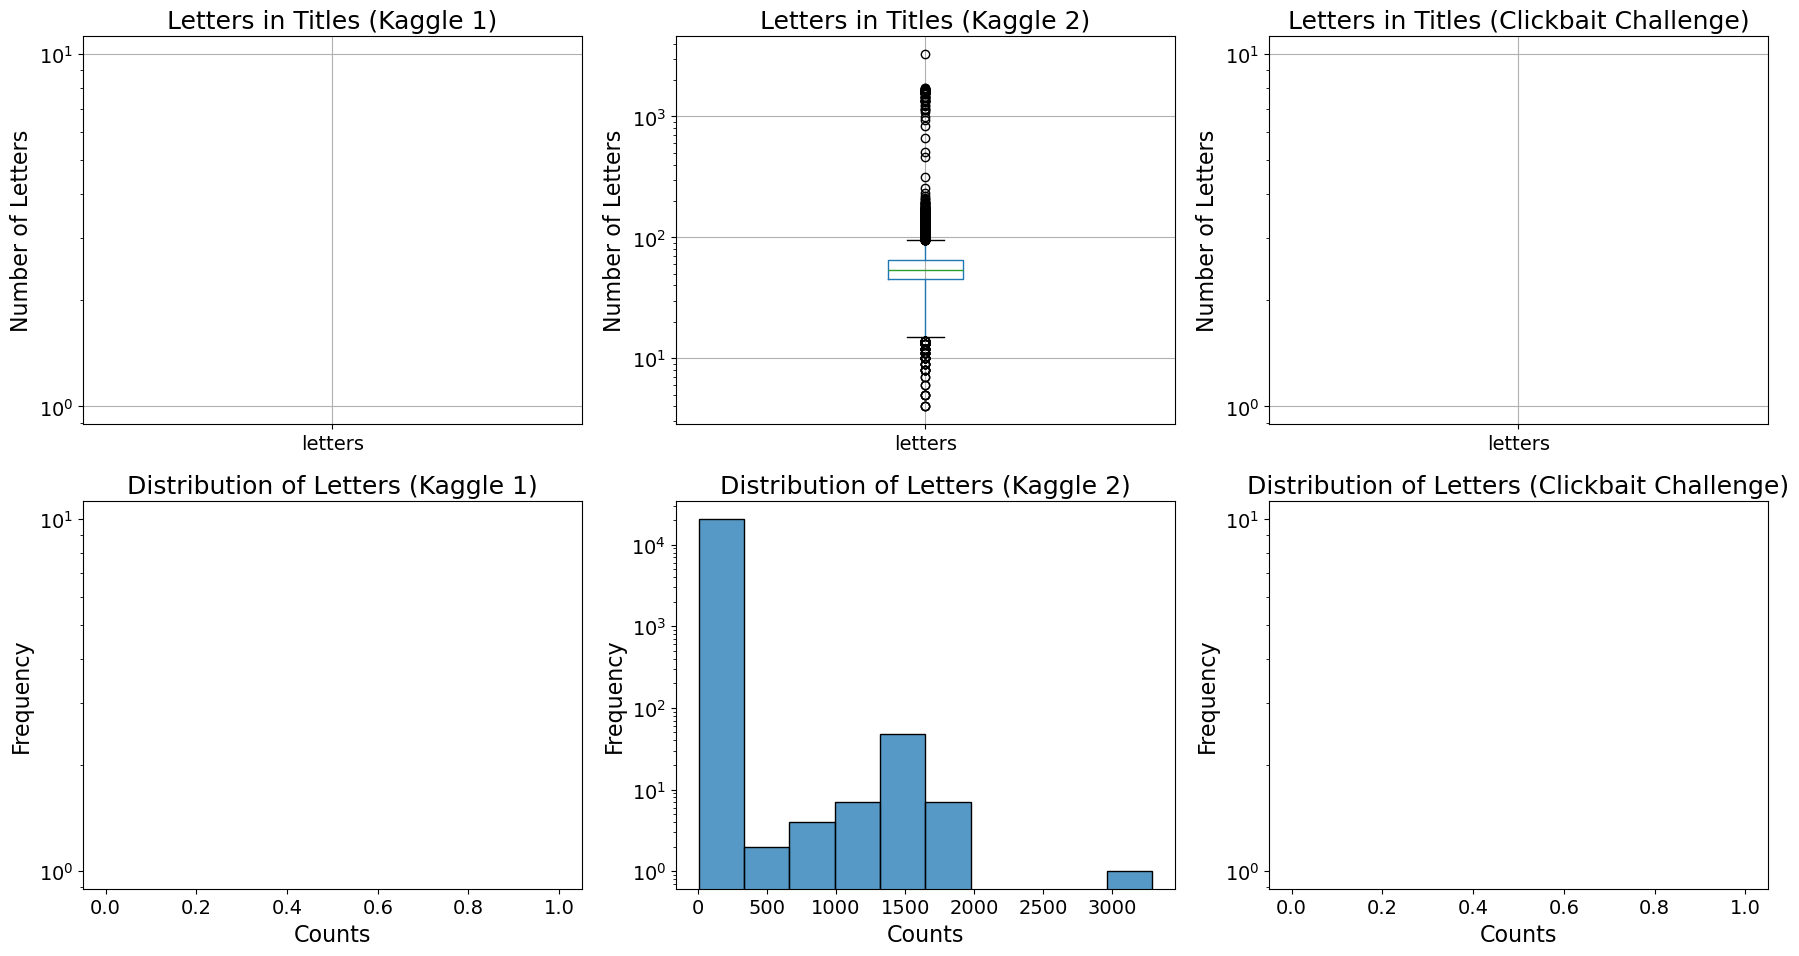

In [88]:
labels = ["Kaggle 1", "Kaggle 2", "Clickbait Challenge"]

def letters_plot_by_set(df, log_scale=False, kde=False):
    # Set font size for the entire figure
    plt.rcParams.update({'font.size': 14})  # Adjust this value for your preference

    # Create subplots: 2 rows, 3 columns
    fig, axs = plt.subplots(2, 3, figsize=(18, 10))

    for i, dataset in enumerate(df['set'].unique().tolist()):
        dataset_df = df[df['set'] == dataset]
        # Create a boxplot for the 'letters' column, grouped by 'set'
        dataset_df.boxplot(column='letters', ax=axs[0, i])
        
        # Set the title and labels for the boxplot
        axs[0, i].set_title(f'Letters in Titles ({labels[i]})', fontsize=18)  # Increased font size
        # axs[0, i].set_xlabel('Letters', fontsize=16)
        axs[0, i].set_ylabel('Number of Letters', fontsize=16)  # Increased font size

        # Remove the default title from the boxplot created by pandas
        plt.suptitle('')  # Suppress the default title to avoid clutter

        # Apply log scale if specified for the boxplot
        if log_scale:
            axs[0, i].set_yscale('log')

    # Create histograms for the 'letters' column for each dataset
    for i, dataset in enumerate(df['set'].unique()):
        dataset_df = df[df['set'] == dataset]  # Filter data for the specific set
        sns.histplot(dataset_df["letters"], bins=10, kde=kde, ax=axs[1, i], edgecolor="black")
        
        # Set titles and labels for histograms
        axs[1, i].set_title(f'Distribution of Letters ({labels[i]})', fontsize=18)  # Increased font size
        axs[1, i].set_xlabel('Counts', fontsize=16)  # Increased font size
        axs[1, i].set_ylabel('Frequency', fontsize=16)  # Increased font size

        # Apply log scale if specified for the histogram
        if log_scale:
            axs[1, i].set_yscale('log')

    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Show the plot
    plt.show()

# Example usage:
# letters_plot_by_set(df_temp, log_scale=True)  # Replace with your actual DataFrame

letters_plot_by_set(df_temp, log_scale=True, kde=False)

In [89]:
# number of duplicates
len(df_merged) - len(df_merged.drop_duplicates(['title', 'clickbait']))

15998

In [90]:
# real number of duplicates. this number is bigger then number above, because there are some duplicated rows with different labels!
len(df_merged) - len(df_merged.drop_duplicates(['title']))

16403

In [91]:
# total number of duplicates with different labels
len(df_merged.drop_duplicates(['title', 'clickbait'])) - len(df_merged.drop_duplicates(['title', 'clickbait']).drop_duplicates(['title'], keep=False))

810

In [92]:
# first, we drop duplicates and leave one row for each duplicated row. then we drop all other title duplicates, as those have different clickbait labels.
df_merged = df_merged.drop_duplicates(['title', 'clickbait']).drop_duplicates(['title'], keep=False)

In [93]:
df_0_huge = df_merged[df_merged['clickbait'] == 0].sample(n=20000, random_state=42)
df_1_huge = df_merged[df_merged['clickbait'] == 1].sample(n=20000, random_state=42)
df_balanced_huge = pd.concat([df_0_huge, df_1_huge])

df_balanced_huge.to_csv("../data/merged_datasetes_balanced_huge.csv", index=False)

In [94]:
x_train, x_test, y_train, y_test = train_test_split(
    df_balanced_huge["title"], 
    df_balanced_huge["clickbait"],
    test_size=0.2, 
    random_state=42,
    stratify=df_balanced_huge["clickbait"]
)


NaN titles dropped: False


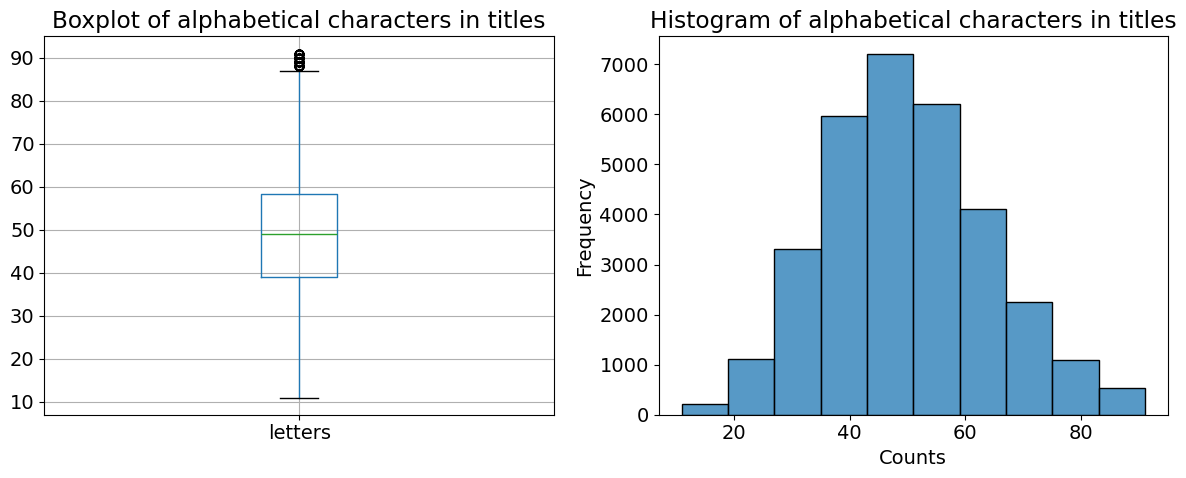

In [95]:
train_df = pd.concat([x_train, y_train], axis=1)
train_df = text_analysis(train_df)
plot_letters(train_df, log_scale=False)


NaN titles dropped: False


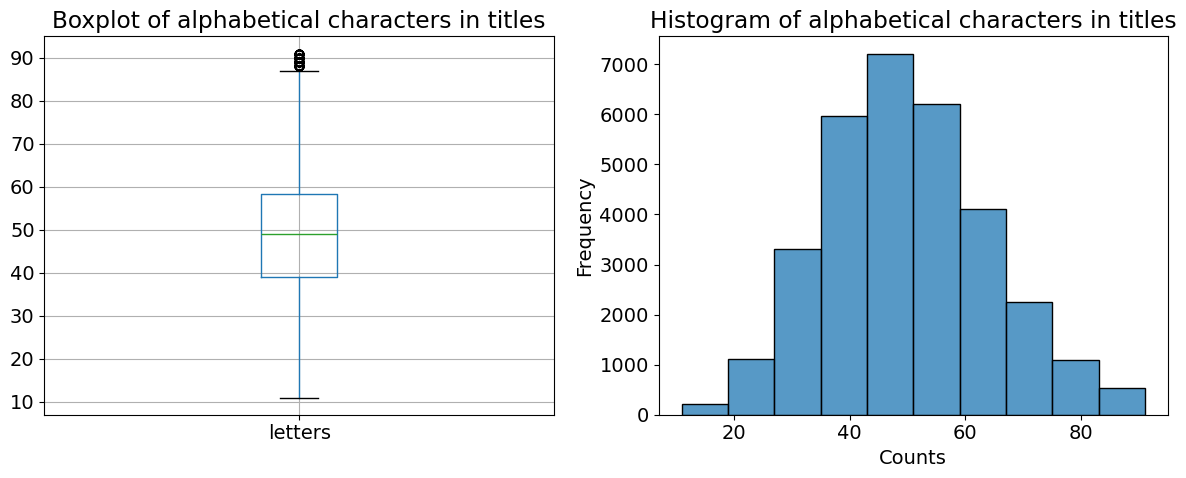

In [96]:
test_df = pd.concat([x_test, y_test], axis=1)
test_df = text_analysis(test_df)
plot_letters(train_df, log_scale=False)

Columns: ['title', 'clickbait', 'set', 'char_capital', 'char_small', 'char_special', 'blank', 'numerical', 'letters', 'outlier']

Shape: (40000, 10)
Number of clickbaits: 20000
Number of no-clickbaits: 20000


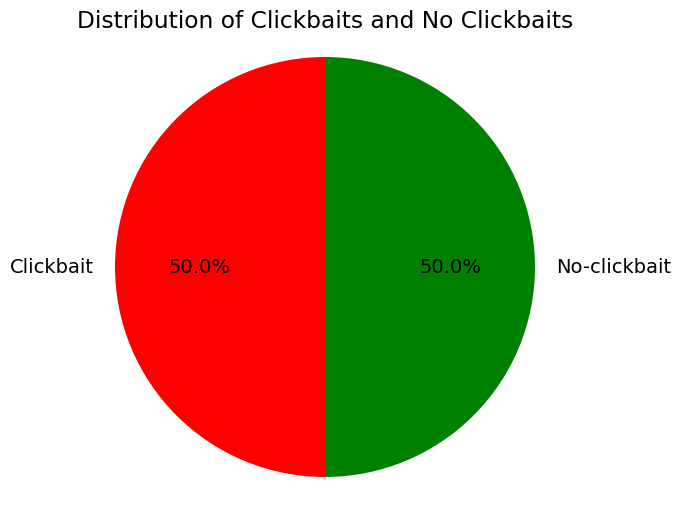


NaN titles dropped: False

Stats:
                set           char_capital           char_small             \
              mean       std         mean       std       mean        std   
clickbait                                                                   
0          1.98775  0.817027      6.01860  3.939357    44.9658  13.591923   
1          1.54005  0.793491      8.78685  3.807170    38.7869  12.565623   

          char_special              blank           numerical            \
                  mean       std     mean       std      mean       std   
clickbait                                                                 
0              1.32585  1.469585  9.06125  3.052813   0.51230  1.243835   
1              1.05535  1.328787  9.32005  2.892981   0.94925  1.464029   

            letters            outlier       
               mean        std    mean  std  
clickbait                                    
0          50.98440  14.306998     0.0  0.0  
1          47.5737

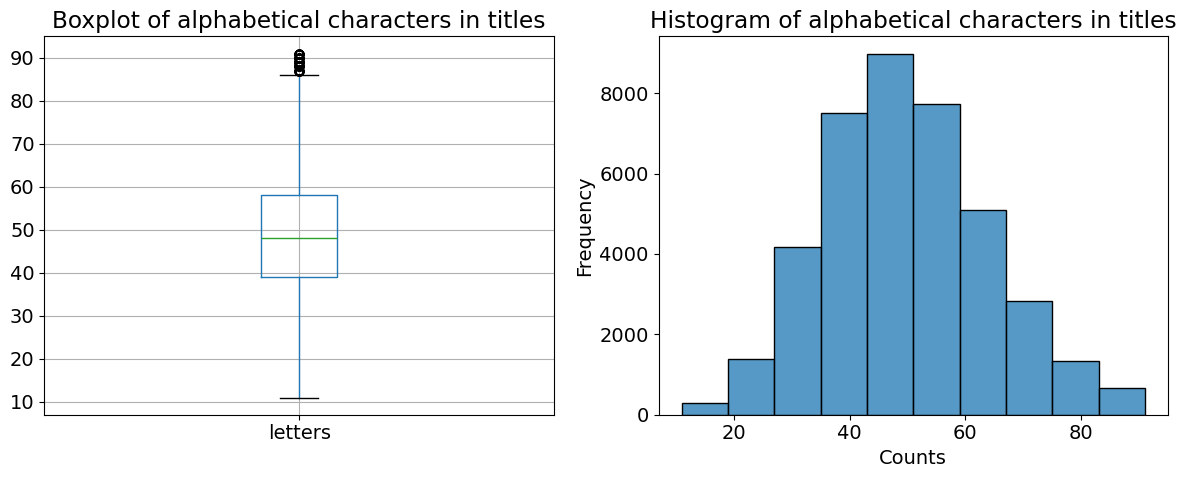

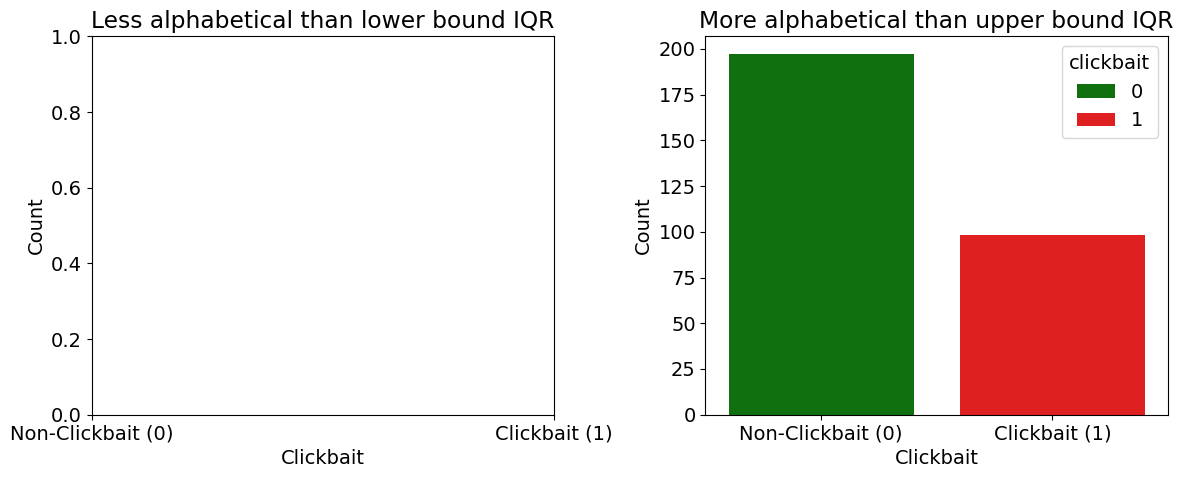

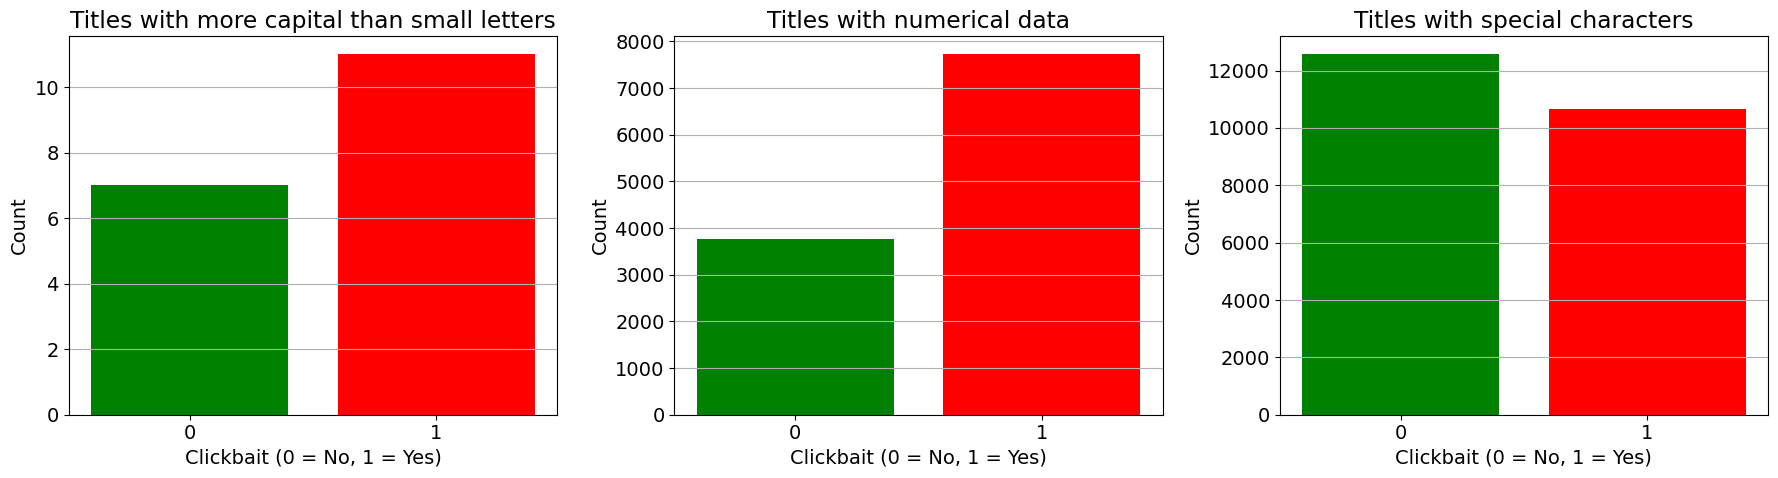

,title,clickbait,set,char_capital,char_small,char_special,blank,numerical,letters,outlier
24812,Boy arrested for murder after seventeen-year-o...,0,1,1,52,2,9,0,53,0
1249,Canada unveils plans to legalise recreational ...,0,2,1,48,0,6,0,49,0
18641,Martin Shkreli Wins Ruling Splitting Fraud Tri...,0,2,10,44,1,8,0,54,0
13790,Your 2015 MLB Draft Prep Kit: Spending Strateg...,0,2,15,63,5,15,4,78,0
18329,Oscars: The winners list,0,3,2,18,1,3,0,20,0
...,...,...,...,...,...,...,...,...,...,...
12807,This Pregnant Mom Took Her Love Of Starbucks T...,1,2,12,39,0,11,0,51,0
13306,These Official Harry Potter Anime Characters W...,1,1,12,51,0,11,0,63,0
14413,Mapping $27 Billion In Federal Funding Of Amer...,1,2,9,46,2,9,2,55,0
570,24 Forgotten Items All Late '90s Teen Girls We...,1,1,10,45,1,11,4,55,0


In [97]:
analyze_df(df_balanced_huge)

In [98]:
df_0 = df_merged[df_merged['clickbait'] == 0].sample(n=10000, random_state=42)
df_1 = df_merged[df_merged['clickbait'] == 1].sample(n=10000, random_state=42)
df_balanced = pd.concat([df_0, df_1])

df_balanced.to_csv("../data/merged_datasetes_balanced.csv", index=False)

## + Dataset with body: clickbait challange
https://webis.de/events/clickbait-challenge/shared-task.html

In [99]:
files = ["clickbait17-train-170331", "clickbait17-test-170720", "clickbait17-validation-170630"]
body_dfs = []
for filename in files:
    part_df = load_data_cc(filename, columns=["targetParagraphs"])
    part_df['body'] = part_df['targetParagraphs'].apply(lambda x: " ".join(x))
    part_df = part_df[['title', 'body', 'clickbait']]
    body_dfs.append(part_df)
df_body = pd.concat(body_dfs).reset_index(drop=True)
df_body = df_body.drop_duplicates(['title'])

In [100]:
df_body['clickbait'].value_counts()

clickbait
0    29072
1     9326
Name: count, dtype: int64

In [101]:
df_body.to_csv("../data/cc_dataset.csv", index=False)

In [102]:
df_00 = df_body[df_body['clickbait'] == 0].sample(n=9326, random_state=37)
df_01 = df_body[df_body['clickbait'] == 1].sample(n=9326, random_state=37)

df_body_balanced = pd.concat([df_00, df_01])

In [103]:
df_body_balanced.to_csv("../data/cc_dataset_balanced.csv", index=False)

## Clickbait spoiling dataset

https://pan.webis.de/semeval23/pan23-web/clickbait-challenge.html

In [104]:
"""
Vocab:
task 1: spoiler type classification
task 2: spoiler generation / extraction

Columns:
targetTitle: The title of the linked web page.
targetParagraphs: The main content of the linked web page. Consists of the paragraphs of manually extracted main content.
humanSpoiler: The human generated spoiler (abstractive) for the clickbait post from the linked web page. Beware, there is a lot of missing values.
spoiler: The human extracted spoiler for the clickbait post from the linked web page.
spoilerPositions: The position of the human extracted spoiler for the clickbait post from the linked web page.
tags: The spoiler type (might be "phrase", "passage", or "multi") that is to be classified in task 1 (spoiler type classification).

How to use spoilerPositions:
if `data['spoilerPositions'][0]` is `[[[3, 151], [3, 186]]]`,
then `data['targetParagraphs'][0][3][151:186]` equals `data['spoiler']`
"""

'\nVocab:\ntask 1: spoiler type classification\ntask 2: spoiler generation / extraction\n\nColumns:\ntargetTitle: The title of the linked web page.\ntargetParagraphs: The main content of the linked web page. Consists of the paragraphs of manually extracted main content.\nhumanSpoiler: The human generated spoiler (abstractive) for the clickbait post from the linked web page. Beware, there is a lot of missing values.\nspoiler: The human extracted spoiler for the clickbait post from the linked web page.\nspoilerPositions: The position of the human extracted spoiler for the clickbait post from the linked web page.\ntags: The spoiler type (might be "phrase", "passage", or "multi") that is to be classified in task 1 (spoiler type classification).\n\nHow to use spoilerPositions:\nif `data[\'spoilerPositions\'][0]` is `[[[3, 151], [3, 186]]]`,\nthen `data[\'targetParagraphs\'][0][3][151:186]` equals `data[\'spoiler\']`\n'

In [105]:
names = ['train', 'validation']
spoil_dfs = []
for name in names:
    data_file_path = f'../data/spoiling-clickbait-22/{name}.jsonl'
    with open(data_file_path, 'rb') as file:
        part_df = pd.read_json(file,lines=True)

    part_df['humanSpoiler'] = part_df['provenance'].apply(lambda x: x['humanSpoiler'])
    part_df = part_df[["targetTitle", "targetParagraphs", "humanSpoiler", "spoiler", "spoilerPositions", "tags"]]
    spoil_dfs.append(part_df)
spoil_df = pd.concat(spoil_dfs).reset_index(drop=True)

In [106]:
spoil_df.to_csv("../data/spoiling_data.csv", index=False)

In [107]:
def remove_brackets(text):
  """
  Removes brackets
  """
  if isinstance(text, float):
    return text
  res=""
  brackets = ["[","]","'","\""]
  num_letters = len(text)
  for i in range(num_letters):     
    if text[i] in brackets:
      continue
    res += text[i]
  return res

In [108]:
spoil_df = pd.read_csv("../data/spoiling_data.csv")

In [109]:
spoil_df.head()

,targetTitle,targetParagraphs,humanSpoiler,spoiler,spoilerPositions,tags
0,"Wes Welker Wanted Dinner With Tom Brady, But P...",['It’ll be just like old times this weekend fo...,They Threw A Football,['how about that morning we go throw?'],"[[[3, 151], [3, 186]]]",['passage']
1,Hole In Ozone Layer Expected To Make Full Reco...,['2070 is shaping up to be a great year for Mo...,2070,['2070'],"[[[0, 0], [0, 4]]]",['phrase']
2,Intellectual Stimulation Trumps Money For Empl...,"[""Despite common belief, money isn't the key t...",Intellectual stimulation,['intellectual stimulation'],"[[[1, 186], [1, 210]]]",['phrase']
3,"‘Follow your passion’ is wrong, here are 7 hab...","['It’s common wisdom. Near gospel really, and ...",NaN,['Purpose connects us to something bigger and ...,"[[[11, 25], [11, 101]], [[17, 56], [17, 85]], ...",['multi']
4,Revealed: The perfect way to cook rice so that...,"['Boiling rice may seem simple, but there is a...",NaN,['in a rice cooker'],"[[[5, 60], [5, 76]]]",['phrase']


In [110]:
print(f"Shape before removing null: {spoil_df.shape}")
nan_counts = (spoil_df.isnull() | (spoil_df == '')).sum()
print(nan_counts)
spoil_df = spoil_df.dropna()
print(f"Shape after removing null: {spoil_df.shape}")

Shape before removing null: (4000, 6)
targetTitle           2
targetParagraphs      0
humanSpoiler        640
spoiler               0
spoilerPositions      0
tags                  0
dtype: int64
Shape after removing null: (3358, 6)


In [118]:
position_col = spoil_df["spoilerPositions"]
spoil_df = spoil_df.drop(columns=["spoilerPositions"]).map(remove_brackets)
spoil_df["spoilerPositions"] = position_col
spoil_df.head()

,targetTitle,targetParagraphs,humanSpoiler,spoiler,tags,spoilerPositions
0,"Wes Welker Wanted Dinner With Tom Brady, But P...",It’ll be just like old times this weekend for ...,They Threw A Football,how about that morning we go throw?,passage,"[[[3, 151], [3, 186]]]"
1,Hole In Ozone Layer Expected To Make Full Reco...,2070 is shaping up to be a great year for Moth...,2070,2070,phrase,"[[[0, 0], [0, 4]]]"
2,Intellectual Stimulation Trumps Money For Empl...,"Despite common belief, money isnt the key to e...",Intellectual stimulation,intellectual stimulation,phrase,"[[[1, 186], [1, 210]]]"
5,Heres what happens if your Apple AirPods get l...,One of the biggest surprise announcements at A...,No,"Apple says that if AirPods are lost or stolen,...",passage,"[[[4, 0], [4, 110]]]"
6,The Reason Why Gabor Kiraly Wears THOSE Tracki...,"June 14th 2016 3.3K Shares, They may look like...",Its a lucky charm to him,"The more good games I had in them, the more I ...",passage,"[[[5, 0], [5, 64]]]"


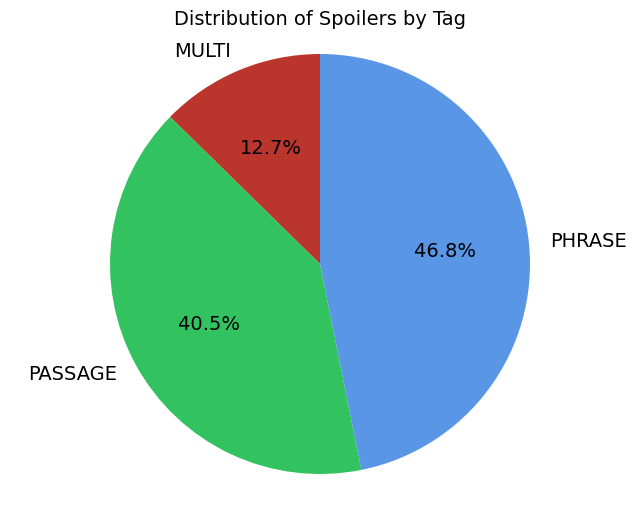

In [112]:
counted_tags = pd.DataFrame(spoil_df.groupby(["tags"]).count()["targetTitle"].reset_index())

labels = [tag.upper() for tag in counted_tags["tags"]]
sizes = counted_tags["targetTitle"]
colors = ["#ba362d", '#32c260', '#5a96e6']
explode = (0, 0, 0)

plt.figure(figsize=(8, 6))
plt.pie(
    sizes,
    explode=explode,
    labels=labels,
    colors=colors,
    autopct='%1.1f%%',
    shadow=False,
    startangle=90,
    textprops={'fontsize': 14}
)
plt.axis('equal')
plt.title('Distribution of Spoilers by Tag', fontsize=14)
plt.show()


NaN titles dropped: False


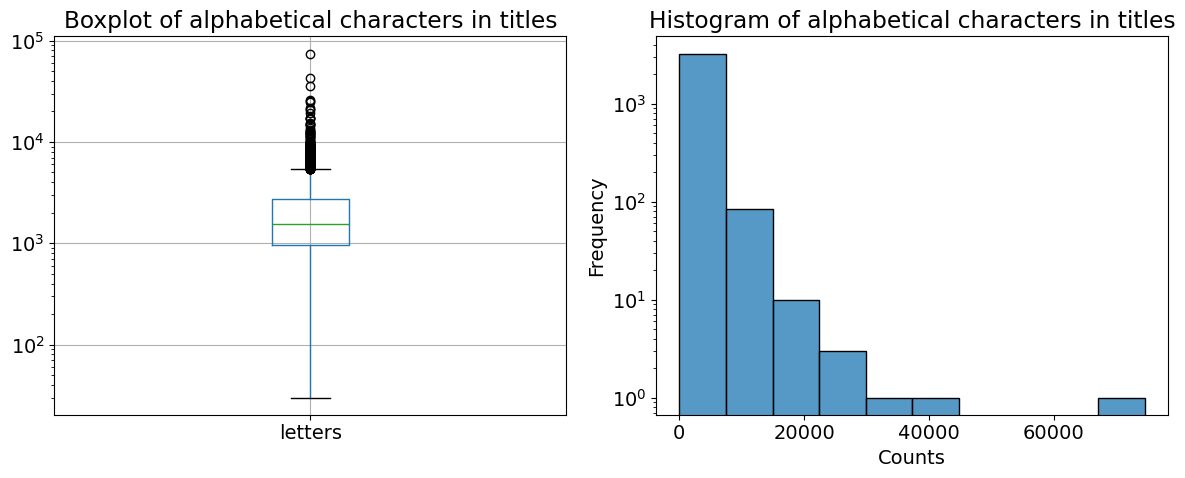

In [113]:
df_targetParagraphs = text_analysis(spoil_df, colname="targetParagraphs")
plot_letters(df_targetParagraphs, log_scale=True)

In [114]:
pd.set_option('display.max_colwidth', None)  # Set to None to display all text

tags = ["passage", "phrase", "multi"]
for tag in tags:
    df = spoil_df.loc[spoil_df["tags"] == tag, ["targetTitle", "humanSpoiler", "spoiler"]].iloc[0:1]
    print(tag)
    print(f"Target title: {df['targetTitle'].to_string(index=False)}")
    print(f"Human spoiler: {df['humanSpoiler'].to_string(index=False)}")
    print(f"Spoiler: {df['spoiler'].to_string(index=False)}")
    print()
pd.set_option('display.max_colwidth', 50)

passage
Target title: Wes Welker Wanted Dinner With Tom Brady, But Patriots QB Had A Better Idea
Human spoiler: They Threw A Football
Spoiler: how about that morning we go throw?

phrase
Target title: Hole In Ozone Layer Expected To Make Full Recovery By 2070: NASA
Human spoiler: 2070
Spoiler: 2070

multi
Target title: Taste test: 29 hot sauce bottles, ranked
Human spoiler: Its Sriracha, its always sriracha
Spoiler: Sriracha Hot Chili Sauce, Franks RedHot Original Sauce, Cholula Chili Garlic, Louisiana Hot Sauce, CaJohns Bourbon Infused Chipotle-Habañero Sauce




NaN titles dropped: False


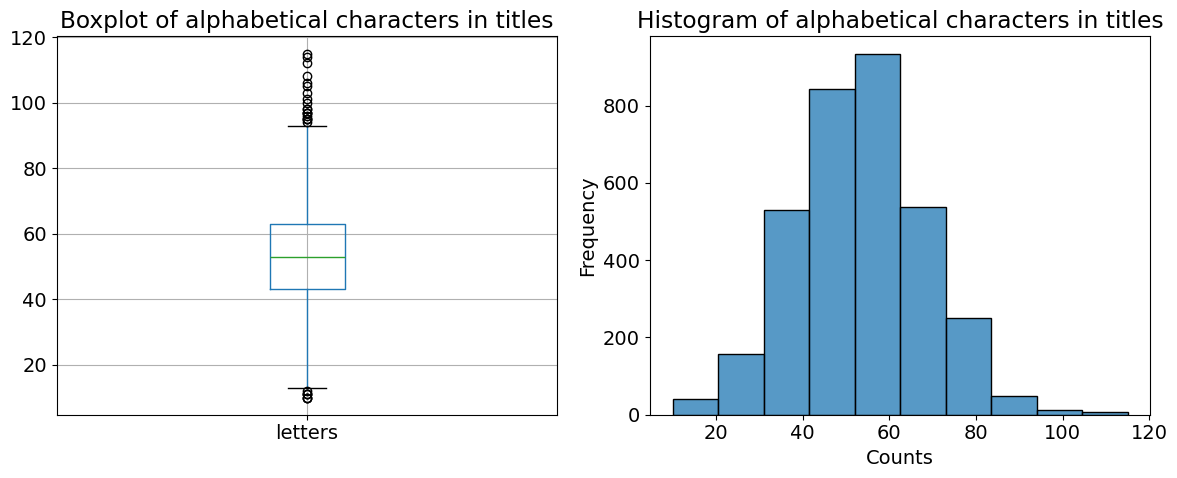

In [115]:
df_targetTitle = text_analysis(spoil_df, colname="targetTitle")
plot_letters(df_targetTitle)

In [116]:
df_humanSpoiler = text_analysis(spoil_df, colname="humanSpoiler")
stats = df_humanSpoiler.drop(columns=["targetTitle",	"targetParagraphs",	"humanSpoiler",	"spoiler", "spoilerPositions"]).groupby('tags').agg(['mean', 'std']).round(1)
print("\nStats:\n", stats)


NaN titles dropped: False

Stats:
         char_capital      char_small       char_special      blank        \
                mean  std       mean   std         mean  std  mean   std   
tags                                                                       
multi            4.0  5.0       53.5  50.6          2.9  3.6  10.6  11.5   
passage          2.9  3.1       47.4  38.5          1.8  2.0   9.5   8.4   
phrase           2.8  2.4       26.4  30.2          1.4  1.8   4.9   6.8   

        numerical      letters        
             mean  std    mean   std  
tags                                  
multi         0.7  2.0    57.5  53.0  
passage       0.4  1.5    50.2  39.5  
phrase        0.5  1.9    29.2  31.1  


In [120]:
spoil_df.to_csv("../data/spoiling_data.csv", index=False)